# Adapting the nice evaluate notebook to see if it works on the TOAR dataset..

Need to work out exactly what we are doing with the transformer architecture. I think we are looking at all surrounding grid cells (denoted as 'context') in the original [paper](https://arxiv.org/pdf/2204.10022.pdf). They apparently do not use context when they estimate with a neural network, since the neural network has no positional encoding...

I still think there is scope here for my representation learning. The key thing is to modify the code of overcast to be able to deal with vector representations rather than just scalars.

In [2]:
import json

import numpy as np

from scipy import stats

from pathlib import Path

from overcast import models
from overcast import datasets
from overcast.models import ensembles

import seaborn as sns
import matplotlib.pyplot as plt

rc = {
    "figure.constrained_layout.use": True,
    "figure.facecolor": "white",
    "axes.labelsize": 20,
    "axes.titlesize": 18,
    "legend.frameon": True,
    "figure.figsize": (6, 6),
    "legend.fontsize": 18,
    "legend.title_fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
}
_ = sns.set(style="whitegrid", palette="colorblind", rc=rc)

In [3]:
# Going to need to edit this...

In [4]:
TARGET_KEYS = {
    0: r"$o3$",
    # 1: r"$CF_w$",
    # 2: r"$\tau$",
    # 3: r"$LWP$",
}

# First we test the treatment effect of NO$_2$

In [48]:
# these are going to change somewhat...but to what!

experiment_dir = Path("/home/jovyan/lustre_scratch/cas/overcast/test_outputs/")
experiment_dir = experiment_dir / "jasmin-daily_treatment-no2_covariates-temp-press-u-v-relhum-cloudcover-pblheight_outcomes-o3_bins-1_bs-True"
experiment_dir = experiment_dir / "appended-treatment-transformer"
experiment_dir = experiment_dir / "dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500"
config_path = experiment_dir / "config.json"
checkpoint_dir = experiment_dir = experiment_dir / "checkpoints"

In [49]:
with open(config_path) as cp:
    config = json.load(cp)

In [50]:
dataset_name = config.get("dataset_name")
num_components_outcome = config.get("num_components_outcome")
num_components_treatment = config.get("num_components_treatment")
dim_hidden = config.get("dim_hidden")
depth = config.get("depth")
num_heads = config.get("num_heads")
negative_slope = config.get("negative_slope")
beta = config.get("beta")
layer_norm = config.get("layer_norm")
dropout_rate = config.get("dropout_rate")
spectral_norm = config.get("spectral_norm")
learning_rate = config.get("learning_rate")
batch_size = config.get("batch_size")
epochs = config.get("epochs")
ensemble_size = config.get("ensemble_size")

In [77]:
config["ds_test"]["root"] = "../../../data/toar_france_countries_timestamp_col_drop_no2_nans.csv"
config["ds_valid"]["root"] = "../../../data/toar_france_countries_timestamp_col_drop_no2_nans.csv"
config["ds_train"]["root"] = "../../../data/toar_france_countries_timestamp_col_drop_no2_nans.csv"
ds = {
    "test": datasets.DATASETS.get(dataset_name)(**config.get("ds_test")),
    "valid": datasets.DATASETS.get(dataset_name)(**config.get("ds_valid")),
    "train": datasets.DATASETS.get(dataset_name)(**config.get("ds_train")),
}

In [78]:
ensemble = []
for ensemble_id in range(ensemble_size):
    model_dir = checkpoint_dir / f"model-{ensemble_id}" / "mu"
    model = models.AppendedTreatmentAttentionNetwork(
        job_dir=model_dir,
        dim_input=ds["train"].dim_input,
        dim_treatment=ds["train"].dim_treatments,
        dim_output=ds["train"].dim_targets,
        num_components_outcome=num_components_outcome,
        num_components_treatment=num_components_treatment,
        dim_hidden=dim_hidden,
        depth=depth,
        num_heads=num_heads,
        negative_slope=negative_slope,
        beta=beta,
        layer_norm=layer_norm,
        spectral_norm=spectral_norm,
        dropout_rate=dropout_rate,
        num_examples=len(ds["train"]),
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=epochs,
        patience=50,
        num_workers=0,
        seed=ensemble_id,
    )
    model.load()
    ensemble.append(model)

2022-12-17 17:59:35,522 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /home/jovyan/lustre_scratch/cas/overcast/test_outputs/jasmin-daily_treatment-no2_covariates-temp-press-u-v-relhum-cloudcover-pblheight_outcomes-o3_bins-1_bs-True/appended-treatment-transformer/dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
2022-12-17 17:59:35,879 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /home/jovyan/lustre_scratch/cas/overcast/test_outputs/jasmin-daily_treatment-no2_covariates-temp-press-u-v-relhum-cloudcover-pblheight_outcomes-o3_bins-1_bs-True/appended-treatment-transformer/dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
2022-12-17 17:59:36,266 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /home/jovyan/lus

## Scatterplots 

In [79]:
means_ensemble = ensembles.predict_mean(ensemble, ds["test"], batch_size=None)
df_test = ds["test"].data_frame
observed_outcomes = df_test.to_numpy()[:, -1:]

In [80]:
2 * 2

4

In [81]:
df_test

,temp,press,u,v,relhum,cloudcover,pblheight,no2,o3
0,10.333333,1008.916687,5.617125,2.831709,85.845833,100.000000,986.299988,25.298676,28.320049
1,7.720833,1002.695862,2.403500,2.305004,88.110001,99.970413,560.808350,53.735149,14.723926
2,7.695833,1004.708313,2.325333,2.161439,88.212502,97.397087,526.641663,49.486038,13.345525
3,9.354167,1000.962524,2.711167,1.295299,84.950417,99.998337,889.960266,42.229824,14.974538
4,9.758333,1003.375000,4.426375,2.440763,82.003334,77.699707,837.591675,6.144897,33.708374
...,...,...,...,...,...,...,...,...,...
169397,9.475000,1000.270813,6.181000,0.616275,82.825417,91.619583,1498.837524,1.372797,37.008217
169398,8.845834,994.520813,6.878208,0.107179,81.834587,97.680420,1536.233276,0.435808,38.738686
169399,11.325000,1013.583313,7.053667,0.054697,84.386665,93.512039,1378.833374,0.261484,42.668064
169400,10.741667,1010.541687,9.350208,-2.191742,72.897919,89.915001,1726.216675,4.772101,42.041489


In [85]:
df_test.to_numpy()[:, -1:].shape

(169402, 1)

In [86]:
means_ensemble.shape

(10, 169402, 1)

In [87]:
observed_outcomes.shape

(169402, 1)

# Transformer lightly trained...

Note we only have one outcome here that we care about...so we edit the original plotting to just do one plot...

Original plotting in the hidden cell below for reference.

IndexError: index 1 is out of bounds for axis 1 with size 1

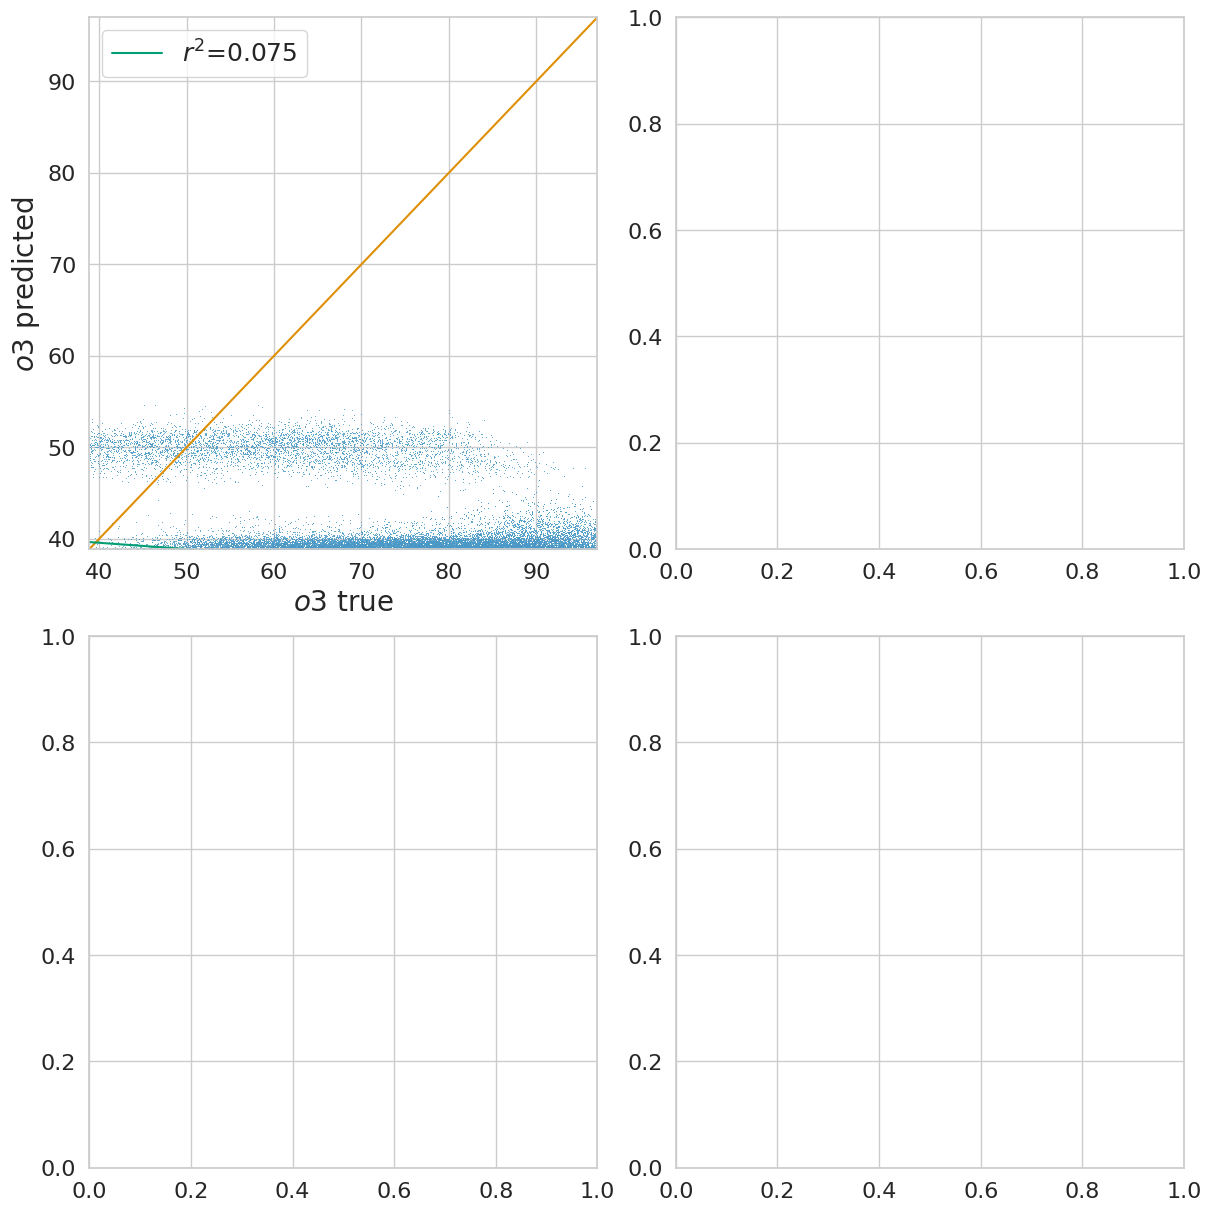

In [16]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

idx_outcome = 0
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax1)
_ = ax1.plot(domain, domain, c="C1")
_ = ax1.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax1.set_xlim(qs)
_ = ax1.set_ylim(qs)
_ = ax1.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax1.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax1.legend(loc="upper left")

idx_outcome = 1
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax2)
_ = ax2.plot(domain, domain, c="C1")
_ = ax2.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax2.set_xlim(qs)
_ = ax2.set_ylim(qs)
_ = ax2.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax2.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax2.legend(loc="upper left")

idx_outcome = 2
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax3)
_ = ax3.plot(domain, domain, c="C1")
_ = ax3.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax3.set_xlim(qs)
_ = ax3.set_ylim(qs)
_ = ax3.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax3.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax3.legend(loc="upper left")

idx_outcome = 3
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax4)
_ = ax4.plot(domain, domain, c="C1")
_ = ax4.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax4.set_xlim(qs)
_ = ax4.set_ylim(qs)
_ = ax4.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax4.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax4.legend(loc="upper left")

In [88]:
qs

array([ 1.8796494, 90.8497467])

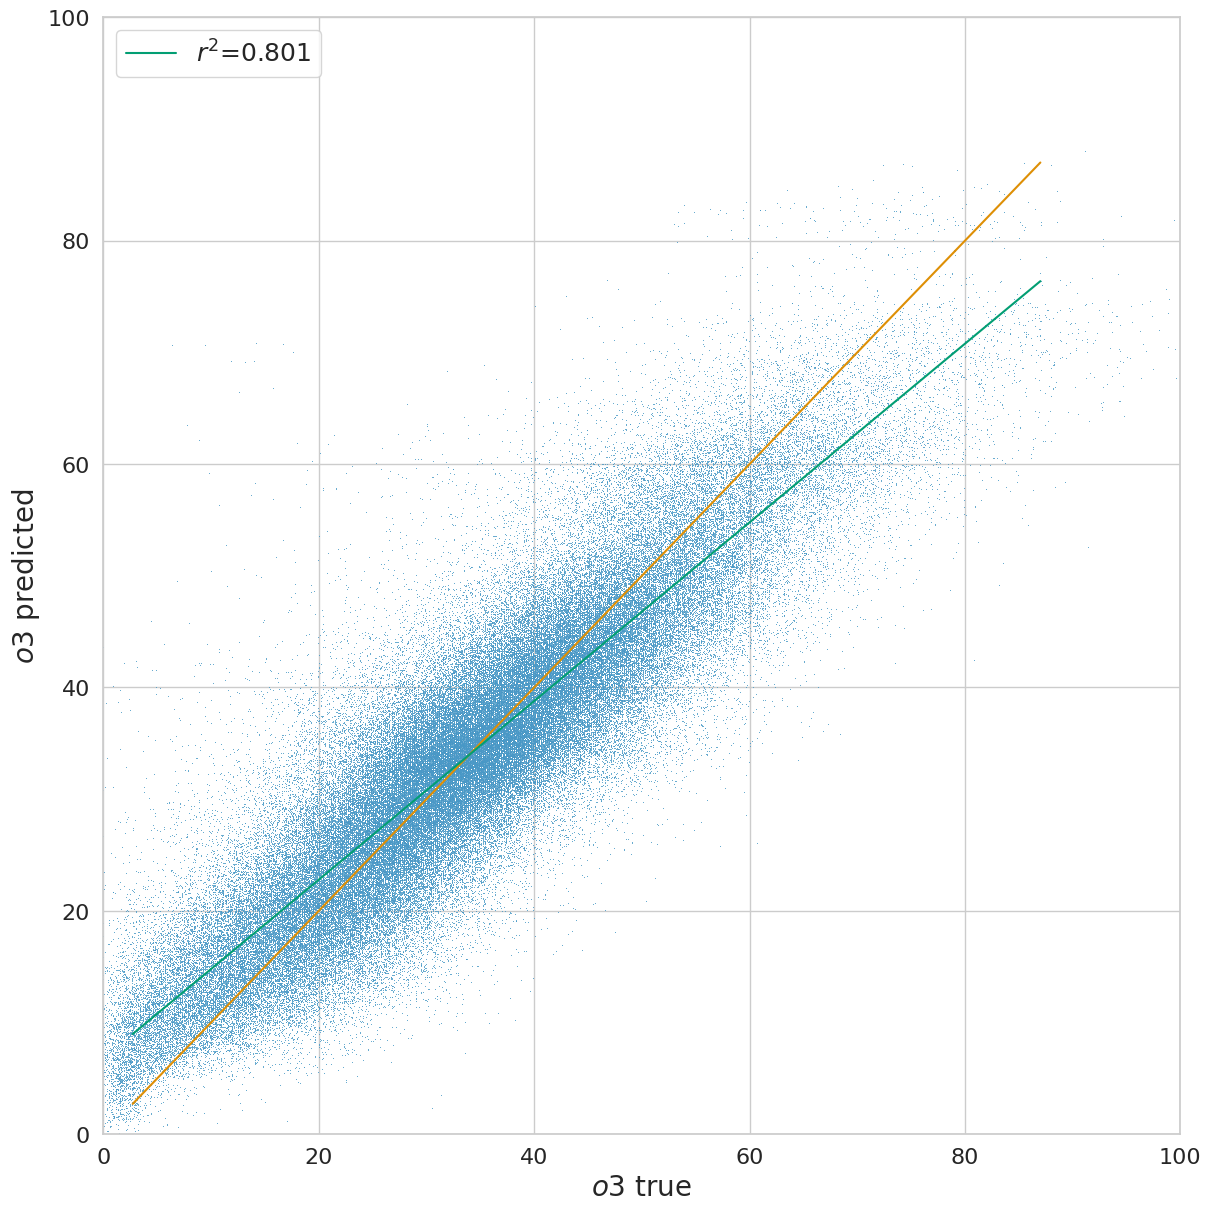

In [99]:
_, ax1 = plt.subplots(1, 1, figsize=(12, 12))

idx_outcome = 0
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.999])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax1)
_ = ax1.plot(domain, domain, c="C1")
_ = ax1.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax1.set_xlim(0, 100)
_ = ax1.set_ylim(0, 100)
#_ = ax1.set_xlim(qs)
#_ = ax1.set_ylim(qs)
_ = ax1.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax1.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax1.legend(loc="upper left")



In [ ]:
# looks good...

## $\Lambda  \to 1.0$

I think I need to be seriously careful here with the apos_ensemble.npy since originally the code just loads it if it exists already. I remedy this below - but note - this predict_capos is very expensive, hence the original code.

In [100]:
treatments = np.concatenate(ds["train"].treatments, axis=0)
treatments = ds["train"].treatments_xfm.inverse_transform(treatments)
treatments = np.quantile(
    treatments,
    q=np.arange(0, 1 + 1 / 32, 1 / 32),
)[:-1]


apos_ensemble_path = Path("apos_ensemble_no2.npy")

capos_ensemble = ensembles.predict_capos(
        ensemble=ensemble, 
        dataset=ds["test"], 
        treatments=treatments, 
        batch_size=1,
    )
apos_ensemble = capos_ensemble.mean(0)
np.save(apos_ensemble_path, apos_ensemble)
    

# old if not else structure that generates the file if we don't have it, otherwise it just loads it in!
#if not apos_ensemble_path.exists():
#    capos_ensemble = ensembles.predict_capos(
#        ensemble=ensemble, 
#        dataset=ds["test"], 
#        treatments=treatments, 
#        batch_size=1,
#    )
#    apos_ensemble = capos_ensemble.mean(0)
#    np.save(apos_ensemble_path, apos_ensemble)
#else:
#    apos_ensemble = np.load(apos_ensemble_path)

In [102]:
TARGET_KEYS

{0: '$o3$'}

In [104]:
apos_ensemble.shape

(10, 169402, 32)

In [105]:
apos_ensemble[0].mean(0)

array([40.535763, 39.47075 , 38.97244 , 38.616142, 38.28489 , 38.00152 ,
       37.719482, 37.43886 , 37.184002, 36.90846 , 36.636127, 36.368767,
       36.11241 , 35.84965 , 35.59933 , 35.335777, 35.080894, 34.815727,
       34.560757, 34.315075, 34.06206 , 33.80315 , 33.555798, 33.30443 ,
       33.048798, 32.7769  , 32.504364, 32.192272, 31.857103, 31.467228,
       30.962887, 30.221544], dtype=float32)

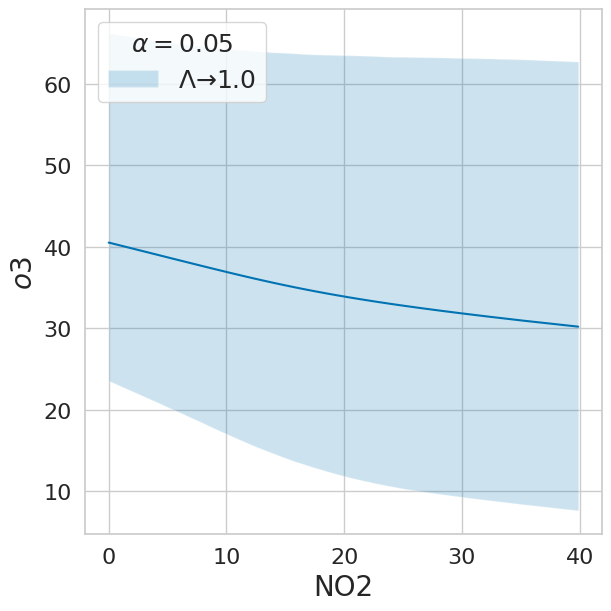

In [106]:
alpha = 0.05
idx_outcome = 0
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0))
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0 $",
)
_ = plt.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = plt.ylabel(TARGET_KEYS[idx_outcome])
_ = plt.xlabel("NO2")

## $\Lambda \to \infty$

In [96]:
log_lambda = 16.0
apo_limits_infty_path = Path("apo_limits_16.0.npy")
if not apo_limits_infty_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_infty = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_infty_path, apo_limits_infty)
else:
    apo_limits_infty = np.load(apo_limits_infty_path)
ymax = np.quantile(apo_limits_infty[1][idx_outcome], 1 - alpha / 2, axis=0)
ymin = np.quantile(apo_limits_infty[0][idx_outcome], alpha / 2, axis=0)
y_range_limit = ymax - ymin
y_range = np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0)
rho_0 = y_range / y_range_limit

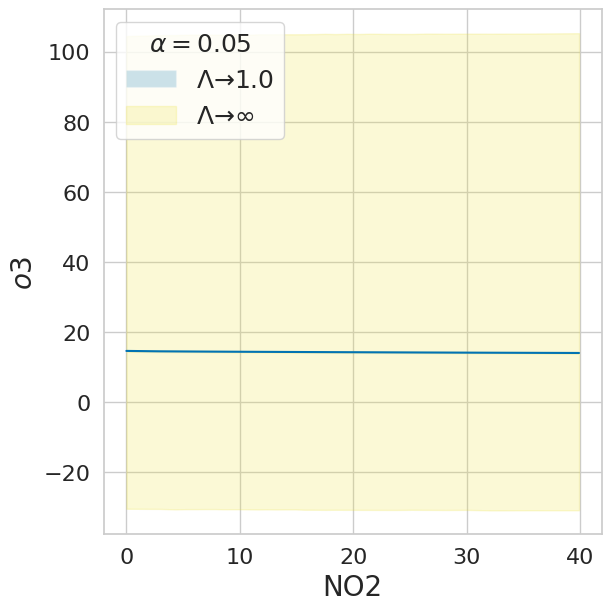

In [97]:
alpha = 0.05
idx_outcome = 0
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0))
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0 $",
)
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
    label=r"$\Lambda \to \infty$",
)
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
)
_ = plt.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = plt.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = plt.ylabel(TARGET_KEYS[idx_outcome])
_ = plt.xlabel("NO2")

## $\Lambda = 1.1$

In [98]:
log_lambda = 0.1
apo_limits_1_path = Path("apo_limits_0.1.npy")
if not apo_limits_1_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_1 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_1_path, apo_limits_1)
else:
    apo_limits_1 = np.load(apo_limits_1_path)
y_range = np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0)
rho_1 = y_range / y_range_limit

KeyboardInterrupt: 

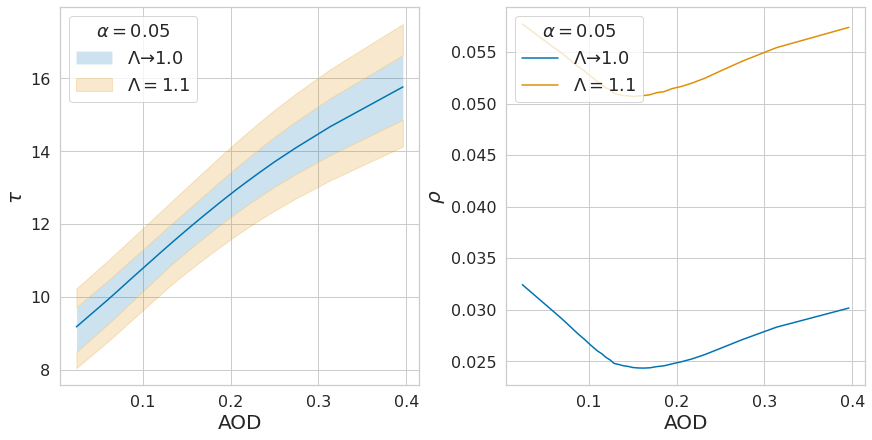

In [15]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax2.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

In [16]:
log_lambda = 0.2
apo_limits_2_path = Path("apo_limits_0.2.npy")
if not apo_limits_2_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_2 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_2_path, apo_limits_2)
else:
    apo_limits_2 = np.load(apo_limits_2_path)
y_range = np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0)
rho_2 = y_range / y_range_limit

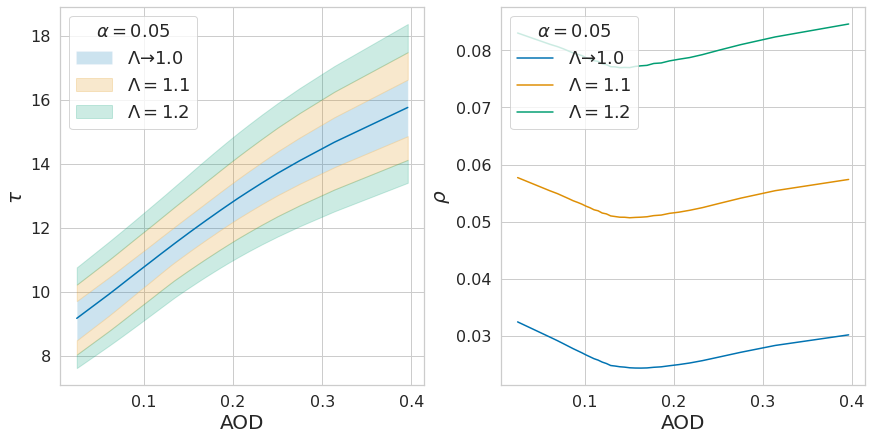

In [17]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
)
_ = ax1.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_2,
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax2.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

In [18]:
log_lambda = 0.5
apo_limits_3_path = Path("apo_limits_0.5.npy")
if not apo_limits_3_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_3 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_3_path, apo_limits_3)
else:
    apo_limits_3 = np.load(apo_limits_3_path)
y_range = np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0)
rho_3 = y_range / y_range_limit

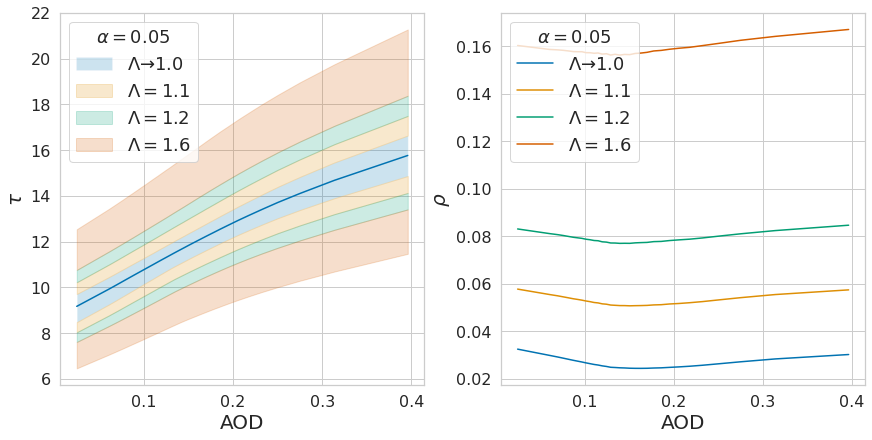

In [19]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
    label=r"$\Lambda=$" + f"{np.exp(0.5):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
)
_ = ax1.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_2,
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_3,
    label=r"$\Lambda=$" + f"{np.exp(0.5):.01f}",
)
_ = ax2.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

In [20]:
log_lambda = 1.0
apo_limits_4_path = Path("apo_limits_1.0.npy")
if not apo_limits_4_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_4 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_4_path, apo_limits_4)
else:
    apo_limits_4 = np.load(apo_limits_4_path)
y_range = np.quantile(apo_limits_4[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_4[0][idx_outcome], alpha / 2, axis=0)
rho_4 = y_range / y_range_limit

In [21]:
log_lambda = 2.0
apo_limits_5_path = Path("apo_limits_2.0.npy")
if not apo_limits_5_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_5 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_5_path, apo_limits_5)
else:
    apo_limits_5 = np.load(apo_limits_5_path)
y_range = np.quantile(apo_limits_5[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_5[0][idx_outcome], alpha / 2, axis=0)
rho_5 = y_range / y_range_limit

In [22]:
log_lambda = 4.0
apo_limits_6_path = Path("apo_limits_4.0.npy")
if not apo_limits_6_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_6 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_6_path, apo_limits_6)
else:
    apo_limits_6 = np.load(apo_limits_6_path)
y_range = np.quantile(apo_limits_6[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_6[0][idx_outcome], alpha / 2, axis=0)
rho_6 = y_range / y_range_limit

In [23]:
log_lambda = 8.0
apo_limits_7_path = Path("apo_limits_8.0.npy")
if not apo_limits_7_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_7 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_7_path, apo_limits_7)
else:
    apo_limits_7 = np.load(apo_limits_7_path)
y_range = np.quantile(apo_limits_7[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_7[0][idx_outcome], alpha / 2, axis=0)
rho_7 = y_range / y_range_limit

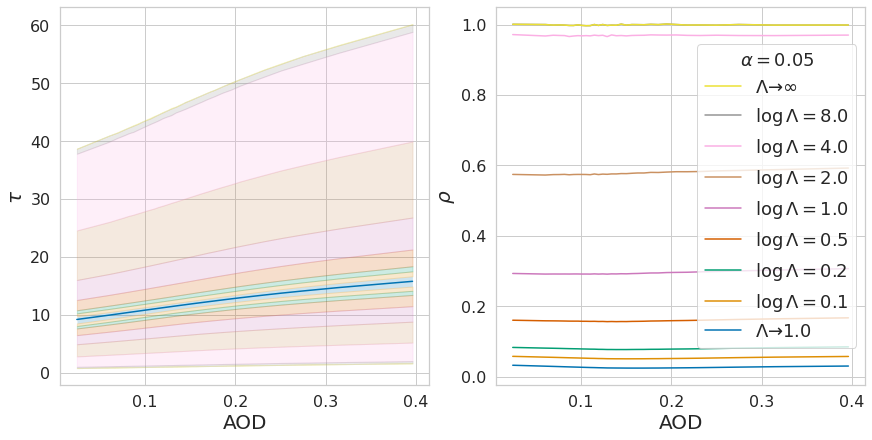

In [24]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
    label=r"$\Lambda=$" + f"{np.exp(0.5):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_4[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C4",
    label=r"$\Lambda=$" + f"{np.exp(1.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_4[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C4",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_5[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_4[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C5",
    label=r"$\Lambda=$" + f"{np.exp(2.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_5[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_4[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C5",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_6[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_5[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C6",
    label=r"$\Lambda=$" + f"{np.exp(4.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_6[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_5[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C6",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_7[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_6[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C7",
    label=r"$\Lambda=$" + f"{np.exp(8.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_7[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_6[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C7",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_7[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
    label=r"$\Lambda\to\infty$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_7[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
)
# _ = ax1.legend(
#     title=r"$\alpha=$" + f"{alpha}",
#     # loc="upper right",
# )
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\log{\Lambda}=0.1$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_2,
    label=r"$\log{\Lambda}=0.2$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_3,
    label=r"$\log{\Lambda}=0.5$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_4,
    label=r"$\log{\Lambda}=1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_5,
    label=r"$\log{\Lambda}=2.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_6,
    label=r"$\log{\Lambda}=4.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_7,
    label=r"$\log{\Lambda}=8.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_7,
    label=r"$\Lambda\to\infty$",
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(
    handles[::-1], 
    labels[::-1], 
    title=r"$\alpha=$" + f"{alpha}", 
    # loc='right'
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

# Repeat for temperature

In [5]:
# these are going to change somewhat...but to what!

experiment_dir = Path("/home/jovyan/lustre_scratch/cas/packages/overcast/test_outputs/")
experiment_dir = experiment_dir / "jasmin-daily_treatment-temp_covariates-press-u-v-pblheight-relhum-cloudcover_outcomes-o3_bins-1_bs-True"
experiment_dir = experiment_dir / "appended-treatment-transformer"
experiment_dir = experiment_dir / "dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500"
config_path = experiment_dir / "config.json"
checkpoint_dir = experiment_dir = experiment_dir / "checkpoints"

In [6]:
with open(config_path) as cp:
    config = json.load(cp)

In [7]:
dataset_name = config.get("dataset_name")
num_components_outcome = config.get("num_components_outcome")
num_components_treatment = config.get("num_components_treatment")
dim_hidden = config.get("dim_hidden")
depth = config.get("depth")
num_heads = config.get("num_heads")
negative_slope = config.get("negative_slope")
beta = config.get("beta")
layer_norm = config.get("layer_norm")
dropout_rate = config.get("dropout_rate")
spectral_norm = config.get("spectral_norm")
learning_rate = config.get("learning_rate")
batch_size = config.get("batch_size")
epochs = config.get("epochs")
ensemble_size = config.get("ensemble_size")

In [8]:
config["ds_test"]["root"] = "../../../data/toar_reduced_data_timestamp_col.csv"
config["ds_valid"]["root"] = "../../../data/toar_reduced_data_timestamp_col.csv"
config["ds_train"]["root"] = "../../../data/toar_reduced_data_timestamp_col.csv"
ds = {
    "test": datasets.DATASETS.get(dataset_name)(**config.get("ds_test")),
    "valid": datasets.DATASETS.get(dataset_name)(**config.get("ds_valid")),
    "train": datasets.DATASETS.get(dataset_name)(**config.get("ds_train")),
}

In [9]:
ensemble = []
for ensemble_id in range(ensemble_size):
    model_dir = checkpoint_dir / f"model-{ensemble_id}" / "mu"
    model = models.AppendedTreatmentAttentionNetwork(
        job_dir=model_dir,
        dim_input=ds["train"].dim_input,
        dim_treatment=ds["train"].dim_treatments,
        dim_output=ds["train"].dim_targets,
        num_components_outcome=num_components_outcome,
        num_components_treatment=num_components_treatment,
        dim_hidden=dim_hidden,
        depth=depth,
        num_heads=num_heads,
        negative_slope=negative_slope,
        beta=beta,
        layer_norm=layer_norm,
        spectral_norm=spectral_norm,
        dropout_rate=dropout_rate,
        num_examples=len(ds["train"]),
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=epochs,
        patience=50,
        num_workers=0,
        seed=ensemble_id,
    )
    model.load()
    ensemble.append(model)

2022-12-18 11:26:51,820 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /home/jovyan/lustre_scratch/cas/packages/overcast/test_outputs/jasmin-daily_treatment-temp_covariates-press-u-v-pblheight-relhum-cloudcover_outcomes-o3_bins-1_bs-True/appended-treatment-transformer/dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
2022-12-18 11:26:52,466 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /home/jovyan/lustre_scratch/cas/packages/overcast/test_outputs/jasmin-daily_treatment-temp_covariates-press-u-v-pblheight-relhum-cloudcover_outcomes-o3_bins-1_bs-True/appended-treatment-transformer/dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
2022-12-18 11:26:52,797 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /home/

## Scatterplots 

In [11]:
means_ensemble = ensembles.predict_mean(ensemble, ds["test"], batch_size=None)
df_test = ds["test"].data_frame
observed_outcomes = df_test.to_numpy()[:, -1:]

In [12]:
df_test

,press,u,v,pblheight,relhum,cloudcover,temp,o3
0,859.587524,0.440042,0.699099,26.519587,70.789169,75.003624,-2.116667,13.972062
1,981.804138,-4.656333,0.671931,500.508331,89.222916,94.941254,-6.687500,19.924299
2,902.179138,-0.779292,2.813304,250.975433,83.628334,63.836250,-2.366666,27.380238
3,903.754150,0.387000,-1.472767,79.557487,91.297081,88.292503,-7.308332,10.463391
4,985.462524,-1.556625,-0.463299,248.462494,92.179169,100.000000,-5.158333,16.603575
...,...,...,...,...,...,...,...,...
142646,1015.291687,2.323417,0.560330,395.291656,87.971252,48.111832,5.120833,31.578100
142647,996.120850,3.176500,1.933879,718.266663,90.437080,50.229626,3.154166,28.695988
142648,1002.887512,3.872612,1.501267,648.887512,85.695831,68.430115,3.354167,36.214577
142649,1016.833313,3.453958,0.533732,634.125000,79.994164,22.505625,8.004167,33.081837


In [13]:
df_test.to_numpy()[:, -1:].shape

(142651, 1)

In [14]:
means_ensemble.shape

(10, 142651, 1)

In [15]:
observed_outcomes.shape

(142651, 1)

# Transformer properly trained...

Note we only have one outcome here that we care about...so we edit the original plotting to just do one plot...

Original plotting in the hidden cell below for reference.

IndexError: index 1 is out of bounds for axis 1 with size 1

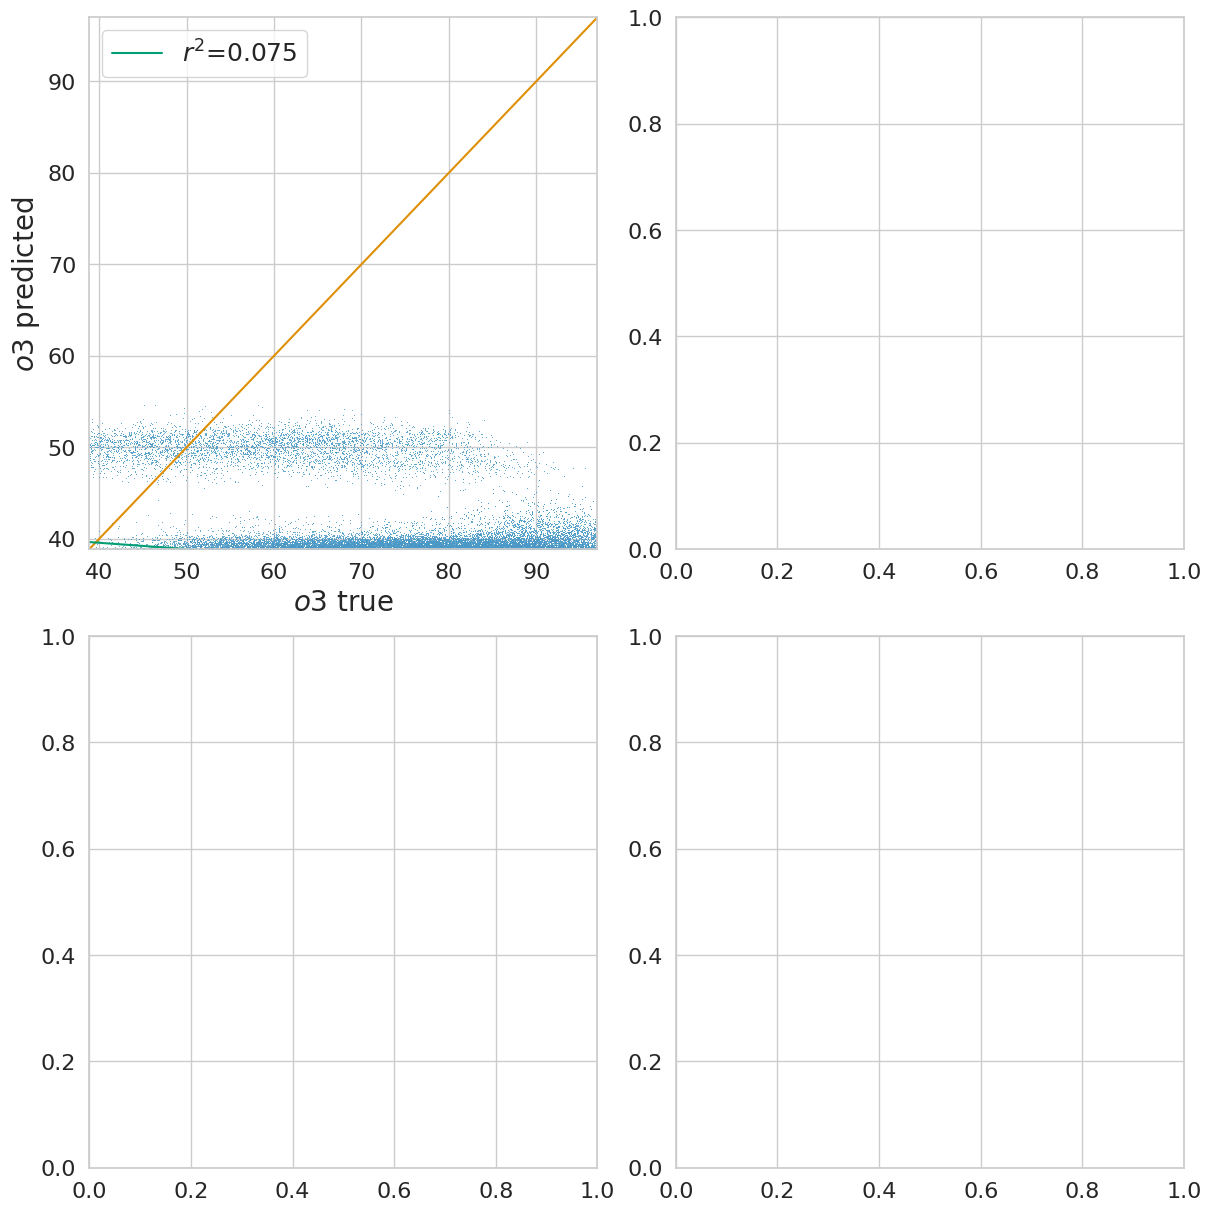

In [16]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

idx_outcome = 0
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax1)
_ = ax1.plot(domain, domain, c="C1")
_ = ax1.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax1.set_xlim(qs)
_ = ax1.set_ylim(qs)
_ = ax1.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax1.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax1.legend(loc="upper left")

idx_outcome = 1
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax2)
_ = ax2.plot(domain, domain, c="C1")
_ = ax2.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax2.set_xlim(qs)
_ = ax2.set_ylim(qs)
_ = ax2.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax2.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax2.legend(loc="upper left")

idx_outcome = 2
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax3)
_ = ax3.plot(domain, domain, c="C1")
_ = ax3.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax3.set_xlim(qs)
_ = ax3.set_ylim(qs)
_ = ax3.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax3.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax3.legend(loc="upper left")

idx_outcome = 3
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax4)
_ = ax4.plot(domain, domain, c="C1")
_ = ax4.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax4.set_xlim(qs)
_ = ax4.set_ylim(qs)
_ = ax4.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax4.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax4.legend(loc="upper left")

In [18]:
qs

array([ 2.07656407, 91.13258171])

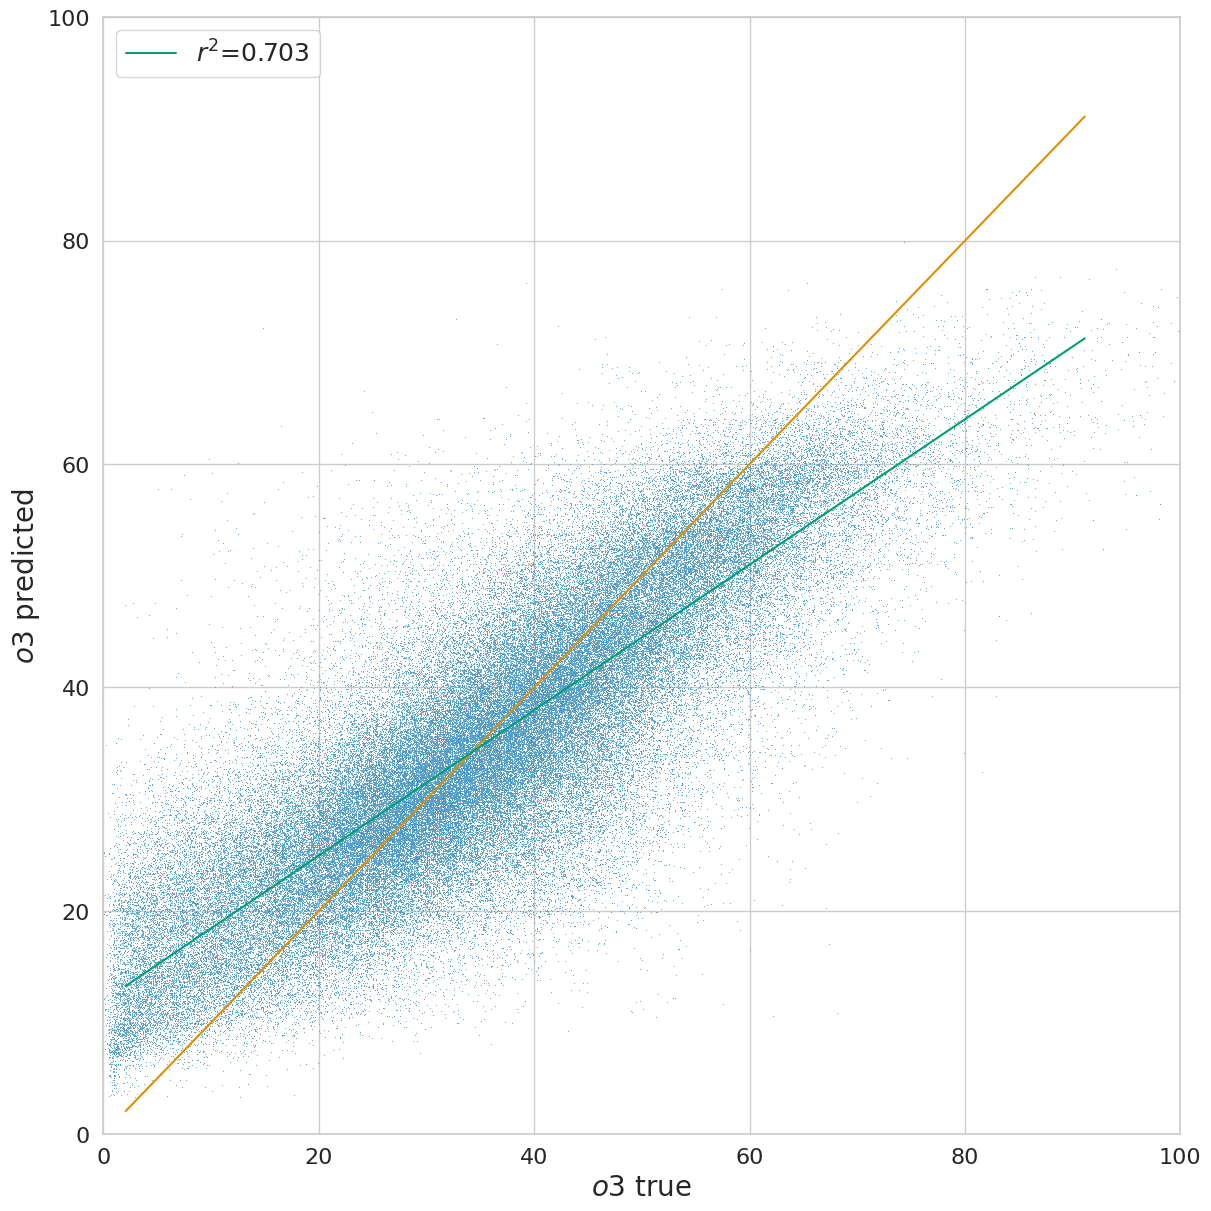

In [17]:
_, ax1 = plt.subplots(1, 1, figsize=(12, 12))

idx_outcome = 0
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.999])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax1)
_ = ax1.plot(domain, domain, c="C1")
_ = ax1.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax1.set_xlim(0, 100)
_ = ax1.set_ylim(0, 100)
#_ = ax1.set_xlim(qs)
#_ = ax1.set_ylim(qs)
_ = ax1.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax1.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax1.legend(loc="upper left")



In [19]:
# looks good...

## $\Lambda  \to 1.0$

I think I need to be seriously careful here with the apos_ensemble.npy since originally the code just loads it if it exists already. I remedy this below - but note - this predict_capos is very expensive, hence the original code.

In [26]:
treatments = np.concatenate(ds["train"].treatments, axis=0)
treatments = ds["train"].treatments_xfm.inverse_transform(treatments)
treatments = np.quantile(
    treatments,
    q=np.arange(0, 1 + 1 / 32, 1 / 32),
)[:-1]

In [ ]:
apos_ensemble_path = Path("apos_ensemble_temp.npy")

capos_ensemble = ensembles.predict_capos(
        ensemble=ensemble, 
        dataset=ds["test"], 
        treatments=treatments, 
        batch_size=1,
    )
apos_ensemble = capos_ensemble.mean(0)
np.save(apos_ensemble_path, apos_ensemble)
    

# old if not else structure that generates the file if we don't have it, otherwise it just loads it in!
#if not apos_ensemble_path.exists():
#    capos_ensemble = ensembles.predict_capos(
#        ensemble=ensemble, 
#        dataset=ds["test"], 
#        treatments=treatments, 
#        batch_size=1,
#    )
#    apos_ensemble = capos_ensemble.mean(0)
#    np.save(apos_ensemble_path, apos_ensemble)
#else:
#    apos_ensemble = np.load(apos_ensemble_path)

In [22]:
apos_ensemble_path = Path("apos_ensemble_temp.npy")
apos_ensemble = np.load(apos_ensemble_path)

In [27]:
apos_ensemble[0].mean(0)

array([37.901783, 34.79123 , 33.85254 , 33.23031 , 32.792953, 32.46757 ,
       32.22661 , 32.027863, 31.851007, 31.70574 , 31.60816 , 31.55823 ,
       31.554422, 31.595194, 31.677689, 31.80441 , 31.972734, 32.183975,
       32.435875, 32.72932 , 33.071617, 33.44303 , 33.830936, 34.23839 ,
       34.6974  , 35.207043, 35.752632, 36.38694 , 37.134533, 38.093517,
       39.298923, 40.986423], dtype=float32)

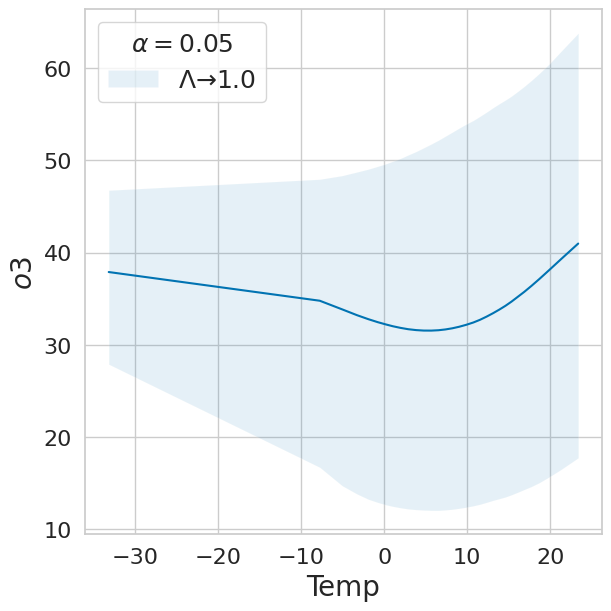

In [35]:
alpha = 0.05
idx_outcome = 0
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0))
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.1,
    label=r"$\Lambda \to 1.0 $",
)
_ = plt.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = plt.ylabel(TARGET_KEYS[idx_outcome])
_ = plt.xlabel("Temp")

## $\Lambda \to \infty$

In [96]:
log_lambda = 16.0
apo_limits_infty_path = Path("apo_limits_16.0_temp.npy")
if not apo_limits_infty_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_infty = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_infty_path, apo_limits_infty)
else:
    apo_limits_infty = np.load(apo_limits_infty_path)
ymax = np.quantile(apo_limits_infty[1][idx_outcome], 1 - alpha / 2, axis=0)
ymin = np.quantile(apo_limits_infty[0][idx_outcome], alpha / 2, axis=0)
y_range_limit = ymax - ymin
y_range = np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0)
rho_0 = y_range / y_range_limit

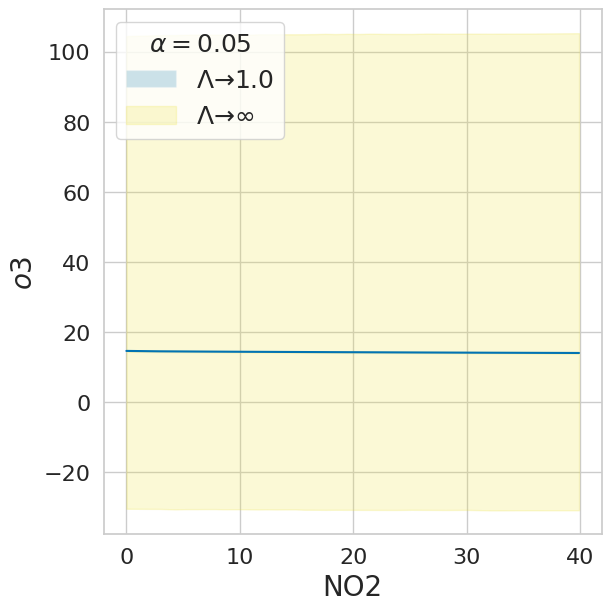

In [97]:
alpha = 0.05
idx_outcome = 0
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0))
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0 $",
)
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
    label=r"$\Lambda \to \infty$",
)
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
)
_ = plt.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = plt.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = plt.ylabel(TARGET_KEYS[idx_outcome])
_ = plt.xlabel("NO2")

## $\Lambda = 1.1$

In [98]:
log_lambda = 0.1
apo_limits_1_path = Path("apo_limits_0.1.npy")
if not apo_limits_1_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_1 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_1_path, apo_limits_1)
else:
    apo_limits_1 = np.load(apo_limits_1_path)
y_range = np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0)
rho_1 = y_range / y_range_limit

KeyboardInterrupt: 

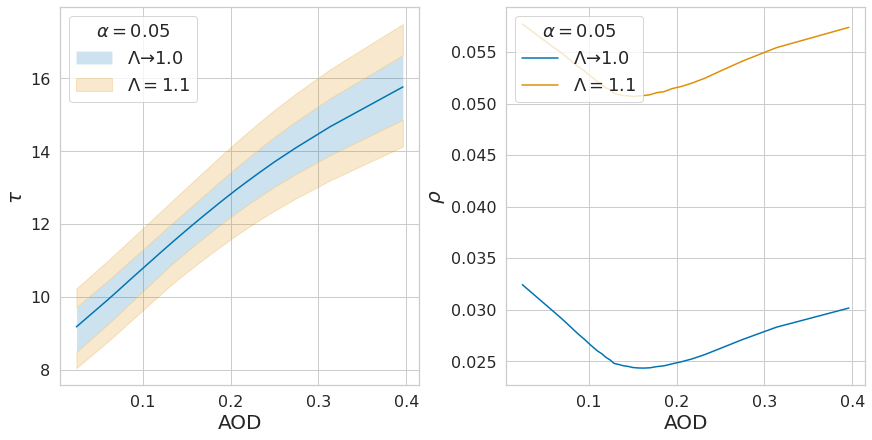

In [15]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax2.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

In [16]:
log_lambda = 0.2
apo_limits_2_path = Path("apo_limits_0.2.npy")
if not apo_limits_2_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_2 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_2_path, apo_limits_2)
else:
    apo_limits_2 = np.load(apo_limits_2_path)
y_range = np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0)
rho_2 = y_range / y_range_limit

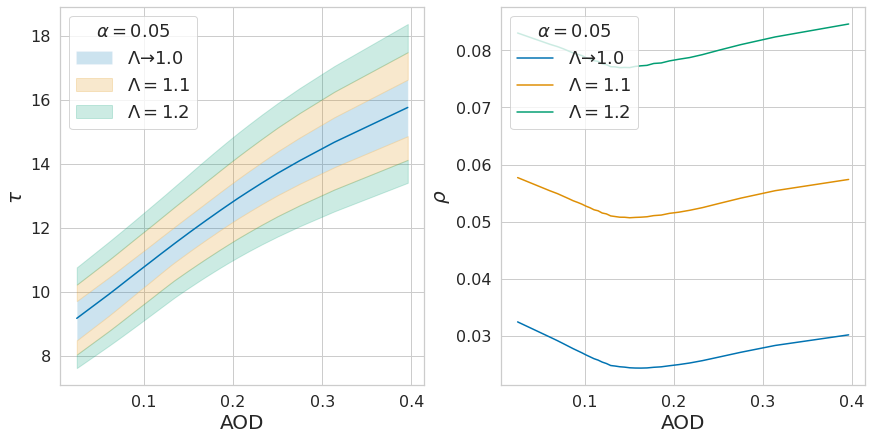

In [17]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
)
_ = ax1.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_2,
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax2.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

In [18]:
log_lambda = 0.5
apo_limits_3_path = Path("apo_limits_0.5.npy")
if not apo_limits_3_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_3 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_3_path, apo_limits_3)
else:
    apo_limits_3 = np.load(apo_limits_3_path)
y_range = np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0)
rho_3 = y_range / y_range_limit

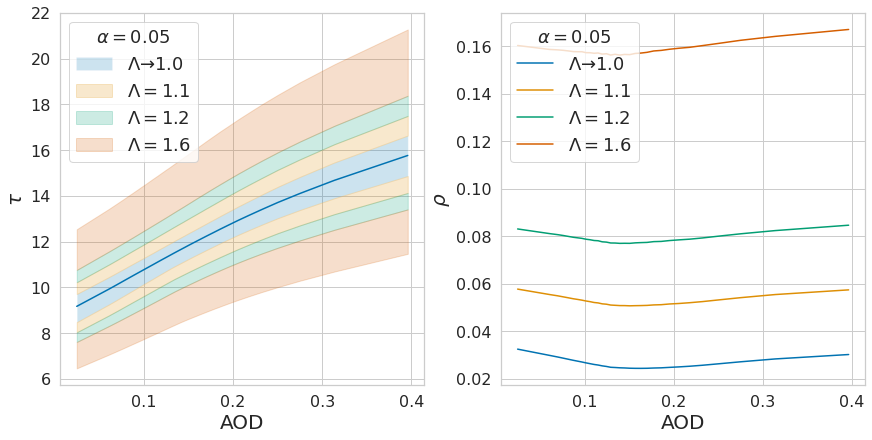

In [19]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
    label=r"$\Lambda=$" + f"{np.exp(0.5):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
)
_ = ax1.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_2,
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_3,
    label=r"$\Lambda=$" + f"{np.exp(0.5):.01f}",
)
_ = ax2.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

In [20]:
log_lambda = 1.0
apo_limits_4_path = Path("apo_limits_1.0.npy")
if not apo_limits_4_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_4 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_4_path, apo_limits_4)
else:
    apo_limits_4 = np.load(apo_limits_4_path)
y_range = np.quantile(apo_limits_4[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_4[0][idx_outcome], alpha / 2, axis=0)
rho_4 = y_range / y_range_limit

In [21]:
log_lambda = 2.0
apo_limits_5_path = Path("apo_limits_2.0.npy")
if not apo_limits_5_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_5 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_5_path, apo_limits_5)
else:
    apo_limits_5 = np.load(apo_limits_5_path)
y_range = np.quantile(apo_limits_5[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_5[0][idx_outcome], alpha / 2, axis=0)
rho_5 = y_range / y_range_limit

In [22]:
log_lambda = 4.0
apo_limits_6_path = Path("apo_limits_4.0.npy")
if not apo_limits_6_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_6 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_6_path, apo_limits_6)
else:
    apo_limits_6 = np.load(apo_limits_6_path)
y_range = np.quantile(apo_limits_6[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_6[0][idx_outcome], alpha / 2, axis=0)
rho_6 = y_range / y_range_limit

In [23]:
log_lambda = 8.0
apo_limits_7_path = Path("apo_limits_8.0.npy")
if not apo_limits_7_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_7 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_7_path, apo_limits_7)
else:
    apo_limits_7 = np.load(apo_limits_7_path)
y_range = np.quantile(apo_limits_7[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_7[0][idx_outcome], alpha / 2, axis=0)
rho_7 = y_range / y_range_limit

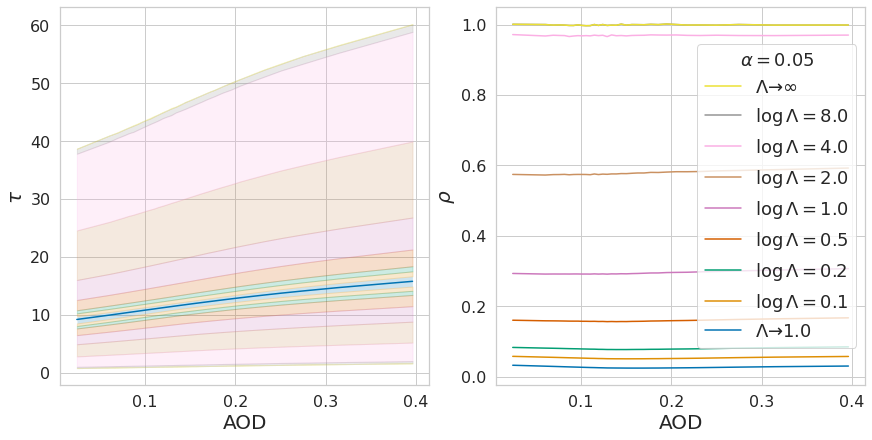

In [24]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
    label=r"$\Lambda=$" + f"{np.exp(0.5):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_4[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C4",
    label=r"$\Lambda=$" + f"{np.exp(1.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_4[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C4",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_5[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_4[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C5",
    label=r"$\Lambda=$" + f"{np.exp(2.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_5[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_4[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C5",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_6[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_5[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C6",
    label=r"$\Lambda=$" + f"{np.exp(4.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_6[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_5[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C6",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_7[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_6[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C7",
    label=r"$\Lambda=$" + f"{np.exp(8.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_7[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_6[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C7",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_7[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
    label=r"$\Lambda\to\infty$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_7[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
)
# _ = ax1.legend(
#     title=r"$\alpha=$" + f"{alpha}",
#     # loc="upper right",
# )
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\log{\Lambda}=0.1$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_2,
    label=r"$\log{\Lambda}=0.2$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_3,
    label=r"$\log{\Lambda}=0.5$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_4,
    label=r"$\log{\Lambda}=1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_5,
    label=r"$\log{\Lambda}=2.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_6,
    label=r"$\log{\Lambda}=4.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_7,
    label=r"$\log{\Lambda}=8.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_7,
    label=r"$\Lambda\to\infty$",
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(
    handles[::-1], 
    labels[::-1], 
    title=r"$\alpha=$" + f"{alpha}", 
    # loc='right'
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

# Repeat for NOx 

In [47]:
# these are going to change somewhat...but to what!
experiment_dir = Path("/home/jovyan/lustre_scratch/cas/packages/overcast/test_outputs/")
experiment_dir = experiment_dir / "jasmin-daily_treatment-nox_covariates-temp-press-u-v-relhum-cloudcover-pblheight_outcomes-o3_bins-1_bs-True"
experiment_dir = experiment_dir / "appended-treatment-transformer"
experiment_dir = experiment_dir / "dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500"
config_path = experiment_dir / "config.json"
checkpoint_dir = experiment_dir = experiment_dir / "checkpoints"

In [48]:
with open(config_path) as cp:
    config = json.load(cp)

In [49]:
dataset_name = config.get("dataset_name")
num_components_outcome = config.get("num_components_outcome")
num_components_treatment = config.get("num_components_treatment")
dim_hidden = config.get("dim_hidden")
depth = config.get("depth")
num_heads = config.get("num_heads")
negative_slope = config.get("negative_slope")
beta = config.get("beta")
layer_norm = config.get("layer_norm")
dropout_rate = config.get("dropout_rate")
spectral_norm = config.get("spectral_norm")
learning_rate = config.get("learning_rate")
batch_size = config.get("batch_size")
epochs = config.get("epochs")
ensemble_size = config.get("ensemble_size")

In [50]:
config["ds_test"]["root"] = "../../../data/toar_france_countries_timestamp_col_drop_no2_nans_drop_no_nans_with_nox.csv"
config["ds_valid"]["root"] = "../../../data/toar_france_countries_timestamp_col_drop_no2_nans_drop_no_nans_with_nox.csv"
config["ds_train"]["root"] = "../../../data/toar_france_countries_timestamp_col_drop_no2_nans_drop_no_nans_with_nox.csv"
ds = {
    "test": datasets.DATASETS.get(dataset_name)(**config.get("ds_test")),
    "valid": datasets.DATASETS.get(dataset_name)(**config.get("ds_valid")),
    "train": datasets.DATASETS.get(dataset_name)(**config.get("ds_train")),
}

In [51]:
ensemble = []
for ensemble_id in range(ensemble_size):
    model_dir = checkpoint_dir / f"model-{ensemble_id}" / "mu"
    model = models.AppendedTreatmentAttentionNetwork(
        job_dir=model_dir,
        dim_input=ds["train"].dim_input,
        dim_treatment=ds["train"].dim_treatments,
        dim_output=ds["train"].dim_targets,
        num_components_outcome=num_components_outcome,
        num_components_treatment=num_components_treatment,
        dim_hidden=dim_hidden,
        depth=depth,
        num_heads=num_heads,
        negative_slope=negative_slope,
        beta=beta,
        layer_norm=layer_norm,
        spectral_norm=spectral_norm,
        dropout_rate=dropout_rate,
        num_examples=len(ds["train"]),
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=epochs,
        patience=50,
        num_workers=0,
        seed=ensemble_id,
    )
    model.load()
    ensemble.append(model)

2022-12-18 12:08:28,547 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /home/jovyan/lustre_scratch/cas/packages/overcast/test_outputs/jasmin-daily_treatment-nox_covariates-temp-press-u-v-relhum-cloudcover-pblheight_outcomes-o3_bins-1_bs-True/appended-treatment-transformer/dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
2022-12-18 12:08:28,836 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /home/jovyan/lustre_scratch/cas/packages/overcast/test_outputs/jasmin-daily_treatment-nox_covariates-temp-press-u-v-relhum-cloudcover-pblheight_outcomes-o3_bins-1_bs-True/appended-treatment-transformer/dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
2022-12-18 12:08:29,169 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoin

## Scatterplots 

In [52]:
means_ensemble = ensembles.predict_mean(ensemble, ds["test"], batch_size=None)
df_test = ds["test"].data_frame
observed_outcomes = df_test.to_numpy()[:, -1:]

In [53]:
df_test

,temp,press,u,v,relhum,cloudcover,pblheight,nox,o3
0,-1.337500,1012.208313,0.622292,-1.035208,84.199165,4.254361,119.835510,42.345150,19.548363
1,-0.045834,1012.250000,1.295500,1.058292,85.879585,79.443916,126.551483,17.096121,16.415600
2,0.045834,992.029175,0.033375,-1.451292,69.320831,17.591249,134.653748,78.410889,14.786572
3,0.045834,992.029175,0.033375,-1.451292,69.320831,17.591249,134.653748,70.218063,15.663745
4,-2.420834,998.712524,0.933000,-1.048292,81.184166,28.341249,258.050446,28.649349,21.929237
...,...,...,...,...,...,...,...,...,...
40648,7.528261,1003.787476,2.659333,4.422625,85.543747,95.761253,861.812500,1.961138,34.648201
40649,7.341304,997.012512,4.121833,5.940958,87.559998,98.582085,950.533325,0.788796,35.212086
40650,8.202174,1009.125000,1.120600,5.811666,86.699585,92.758751,647.841675,1.307425,34.272289
40651,11.058696,1006.208313,7.035292,7.049271,85.860832,98.321251,1389.895874,5.709004,40.099201


In [54]:
df_test.to_numpy()[:, -1:].shape

(40653, 1)

In [55]:
means_ensemble.shape

(10, 40653, 1)

In [56]:
observed_outcomes.shape

(40653, 1)

# Transformer properly trained...

Note we only have one outcome here that we care about...so we edit the original plotting to just do one plot...

Original plotting in the hidden cell below for reference.

IndexError: index 1 is out of bounds for axis 1 with size 1

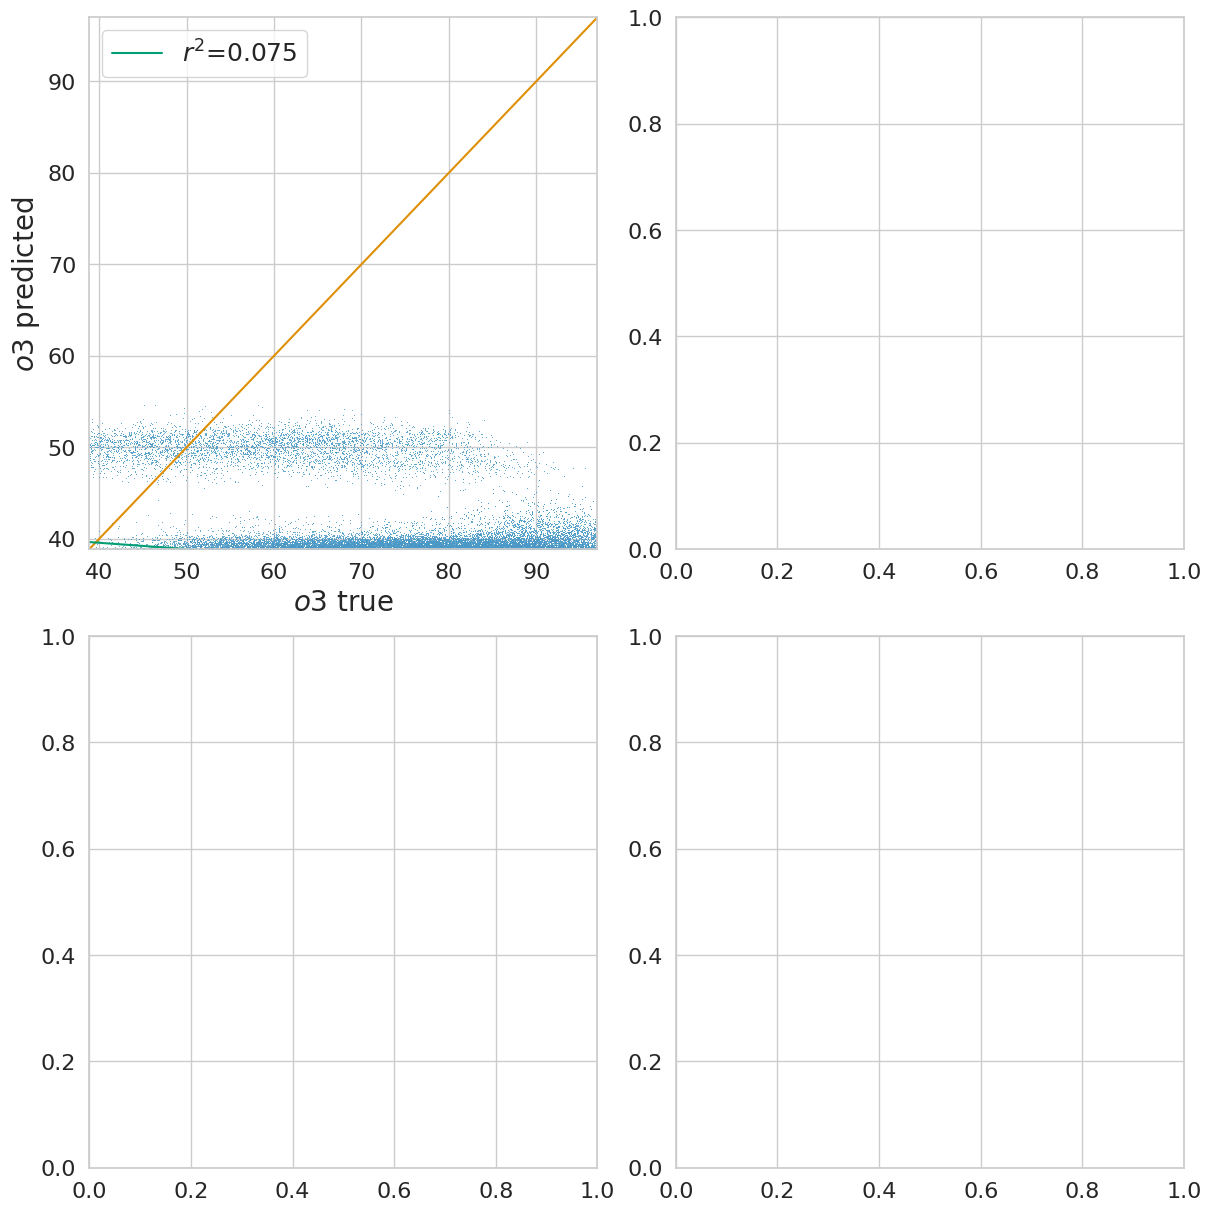

In [16]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

idx_outcome = 0
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax1)
_ = ax1.plot(domain, domain, c="C1")
_ = ax1.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax1.set_xlim(qs)
_ = ax1.set_ylim(qs)
_ = ax1.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax1.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax1.legend(loc="upper left")

idx_outcome = 1
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax2)
_ = ax2.plot(domain, domain, c="C1")
_ = ax2.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax2.set_xlim(qs)
_ = ax2.set_ylim(qs)
_ = ax2.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax2.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax2.legend(loc="upper left")

idx_outcome = 2
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax3)
_ = ax3.plot(domain, domain, c="C1")
_ = ax3.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax3.set_xlim(qs)
_ = ax3.set_ylim(qs)
_ = ax3.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax3.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax3.legend(loc="upper left")

idx_outcome = 3
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax4)
_ = ax4.plot(domain, domain, c="C1")
_ = ax4.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax4.set_xlim(qs)
_ = ax4.set_ylim(qs)
_ = ax4.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax4.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax4.legend(loc="upper left")

In [57]:
qs

array([ 2.07656407, 91.13258171])

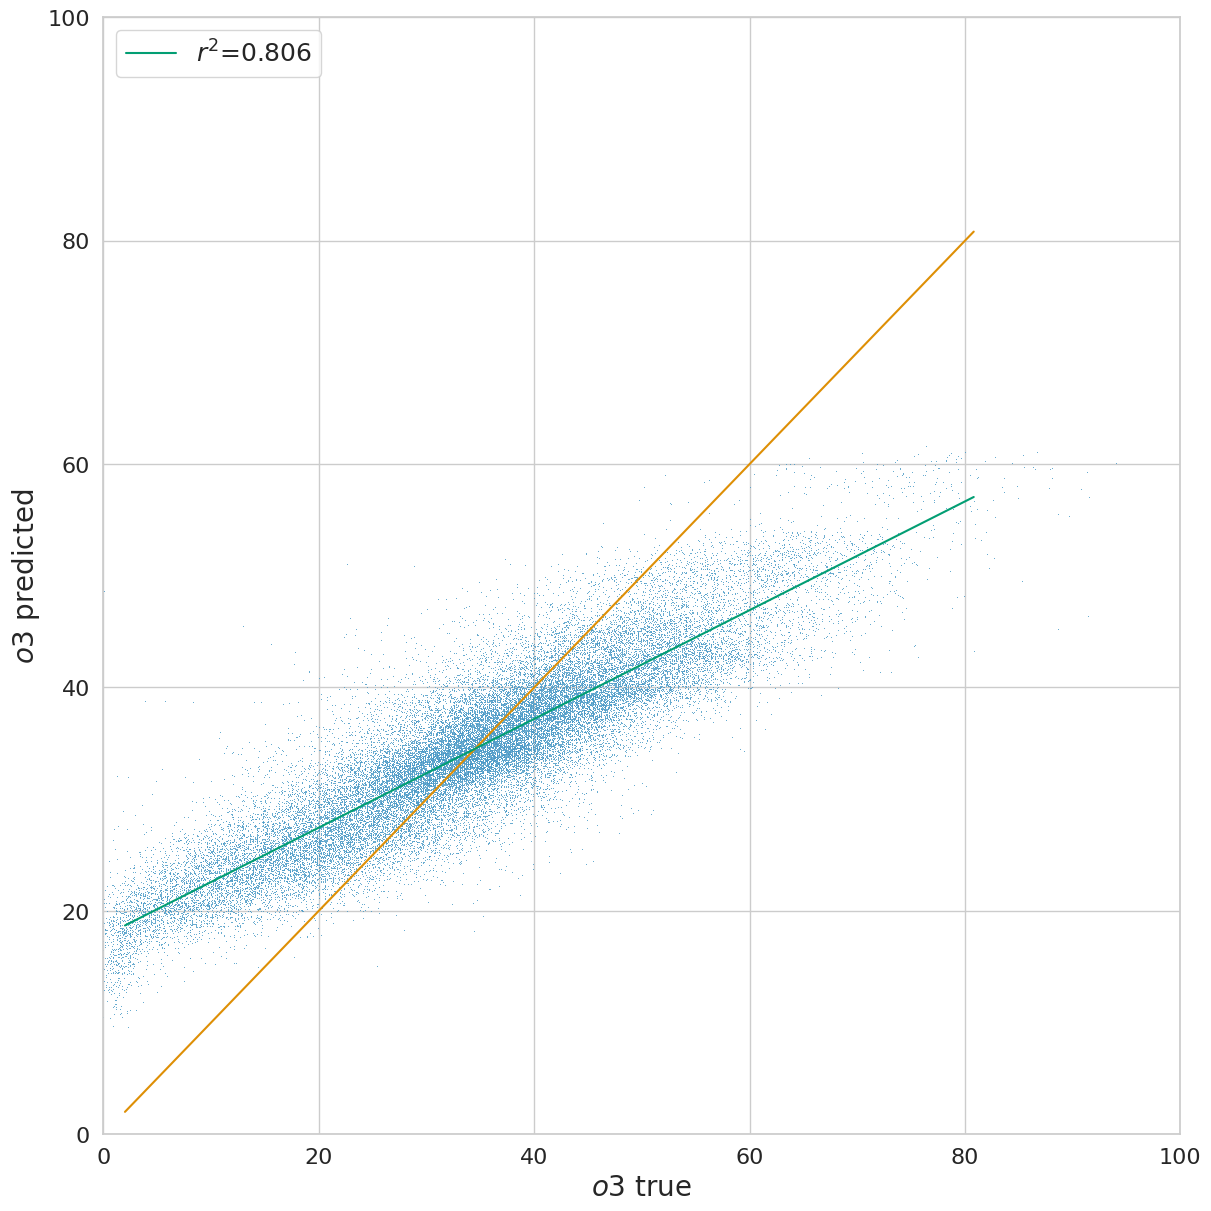

In [58]:
_, ax1 = plt.subplots(1, 1, figsize=(12, 12))

idx_outcome = 0
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.999])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax1)
_ = ax1.plot(domain, domain, c="C1")
_ = ax1.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax1.set_xlim(0, 100)
_ = ax1.set_ylim(0, 100)
#_ = ax1.set_xlim(qs)
#_ = ax1.set_ylim(qs)
_ = ax1.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax1.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax1.legend(loc="upper left")



In [19]:
# looks good...

## $\Lambda  \to 1.0$

I think I need to be seriously careful here with the apos_ensemble.npy since originally the code just loads it if it exists already. I remedy this below - but note - this predict_capos is very expensive, hence the original code.

In [59]:
treatments = np.concatenate(ds["train"].treatments, axis=0)
treatments = ds["train"].treatments_xfm.inverse_transform(treatments)
treatments = np.quantile(
    treatments,
    q=np.arange(0, 1 + 1 / 32, 1 / 32),
)[:-1]

In [ ]:
apos_ensemble_path = Path("apos_ensemble_nox.npy")

capos_ensemble = ensembles.predict_capos(
        ensemble=ensemble, 
        dataset=ds["test"], 
        treatments=treatments, 
        batch_size=1,
    )
apos_ensemble = capos_ensemble.mean(0)
np.save(apos_ensemble_path, apos_ensemble)
    

# old if not else structure that generates the file if we don't have it, otherwise it just loads it in!
#if not apos_ensemble_path.exists():
#    capos_ensemble = ensembles.predict_capos(
#        ensemble=ensemble, 
#        dataset=ds["test"], 
#        treatments=treatments, 
#        batch_size=1,
#    )
#    apos_ensemble = capos_ensemble.mean(0)
#    np.save(apos_ensemble_path, apos_ensemble)
#else:
#    apos_ensemble = np.load(apos_ensemble_path)

In [ ]:
apos_ensemble_path = Path("apos_ensemble_nox.npy")
apos_ensemble = np.load(apos_ensemble_path)

In [27]:
apos_ensemble[0].mean(0)

array([37.901783, 34.79123 , 33.85254 , 33.23031 , 32.792953, 32.46757 ,
       32.22661 , 32.027863, 31.851007, 31.70574 , 31.60816 , 31.55823 ,
       31.554422, 31.595194, 31.677689, 31.80441 , 31.972734, 32.183975,
       32.435875, 32.72932 , 33.071617, 33.44303 , 33.830936, 34.23839 ,
       34.6974  , 35.207043, 35.752632, 36.38694 , 37.134533, 38.093517,
       39.298923, 40.986423], dtype=float32)

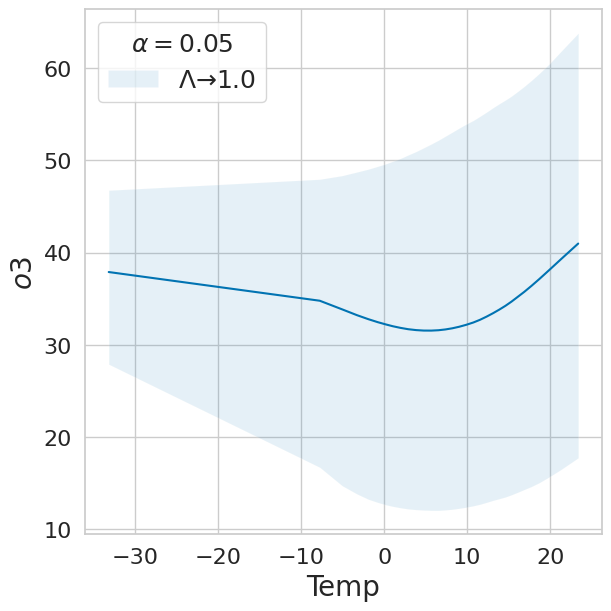

In [35]:
alpha = 0.05
idx_outcome = 0
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0))
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.1,
    label=r"$\Lambda \to 1.0 $",
)
_ = plt.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = plt.ylabel(TARGET_KEYS[idx_outcome])
_ = plt.xlabel("Temp")

## $\Lambda \to \infty$

In [96]:
log_lambda = 16.0
apo_limits_infty_path = Path("apo_limits_16.0_temp.npy")
if not apo_limits_infty_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_infty = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_infty_path, apo_limits_infty)
else:
    apo_limits_infty = np.load(apo_limits_infty_path)
ymax = np.quantile(apo_limits_infty[1][idx_outcome], 1 - alpha / 2, axis=0)
ymin = np.quantile(apo_limits_infty[0][idx_outcome], alpha / 2, axis=0)
y_range_limit = ymax - ymin
y_range = np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0)
rho_0 = y_range / y_range_limit

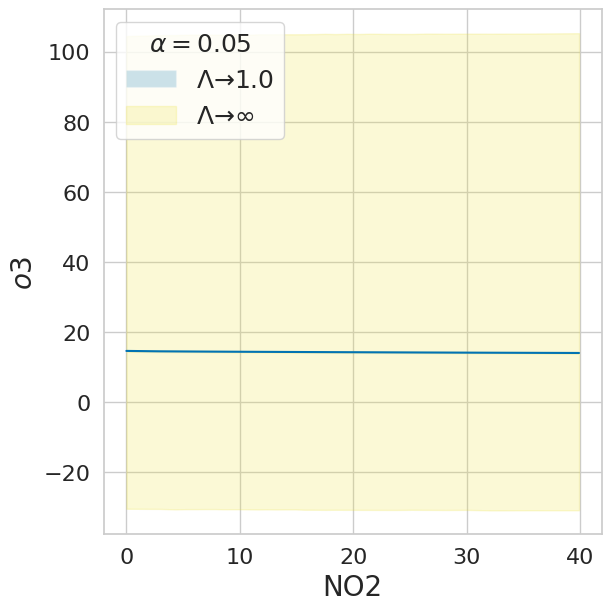

In [97]:
alpha = 0.05
idx_outcome = 0
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0))
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0 $",
)
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
    label=r"$\Lambda \to \infty$",
)
_ = plt.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
)
_ = plt.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = plt.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = plt.ylabel(TARGET_KEYS[idx_outcome])
_ = plt.xlabel("NO2")

## $\Lambda = 1.1$

In [98]:
log_lambda = 0.1
apo_limits_1_path = Path("apo_limits_0.1.npy")
if not apo_limits_1_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_1 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_1_path, apo_limits_1)
else:
    apo_limits_1 = np.load(apo_limits_1_path)
y_range = np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0)
rho_1 = y_range / y_range_limit

KeyboardInterrupt: 

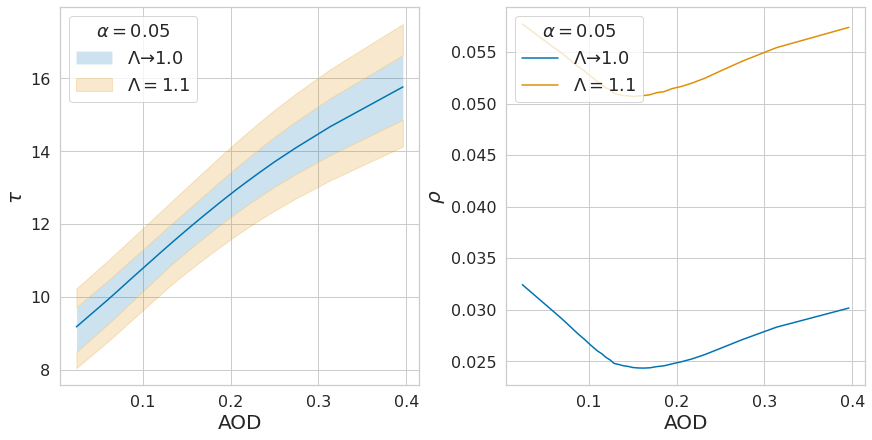

In [15]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax2.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

In [16]:
log_lambda = 0.2
apo_limits_2_path = Path("apo_limits_0.2.npy")
if not apo_limits_2_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_2 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_2_path, apo_limits_2)
else:
    apo_limits_2 = np.load(apo_limits_2_path)
y_range = np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0)
rho_2 = y_range / y_range_limit

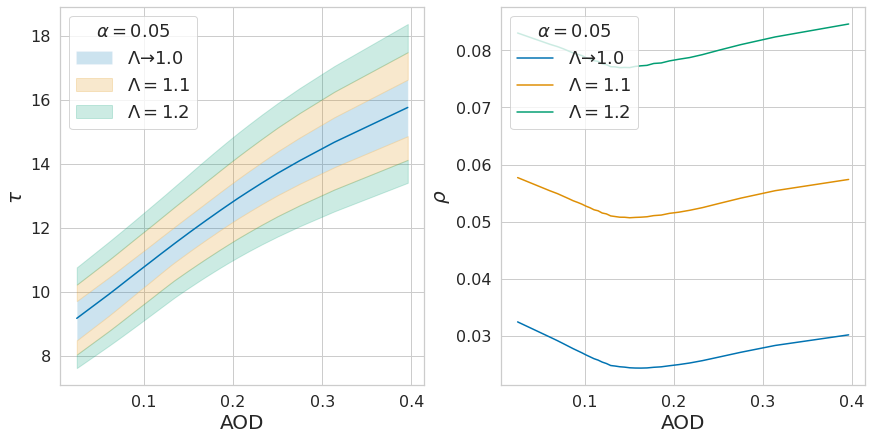

In [17]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
)
_ = ax1.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_2,
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax2.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

In [18]:
log_lambda = 0.5
apo_limits_3_path = Path("apo_limits_0.5.npy")
if not apo_limits_3_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_3 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_3_path, apo_limits_3)
else:
    apo_limits_3 = np.load(apo_limits_3_path)
y_range = np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0)
rho_3 = y_range / y_range_limit

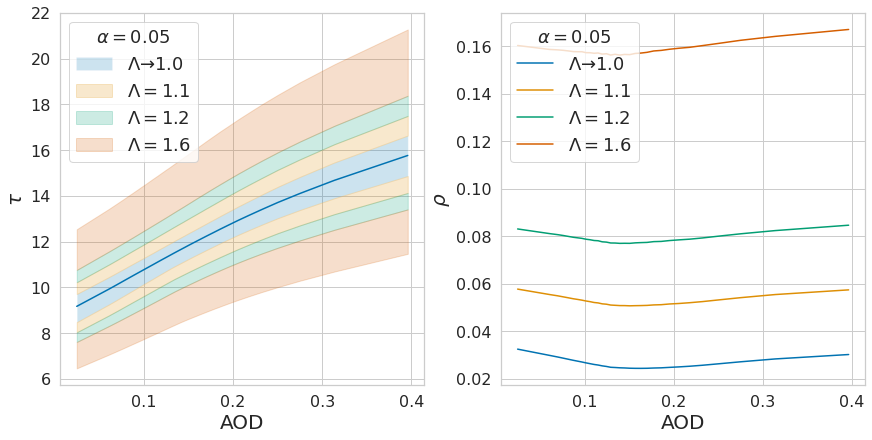

In [19]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
    label=r"$\Lambda=$" + f"{np.exp(0.5):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
)
_ = ax1.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_2,
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_3,
    label=r"$\Lambda=$" + f"{np.exp(0.5):.01f}",
)
_ = ax2.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")

In [20]:
log_lambda = 1.0
apo_limits_4_path = Path("apo_limits_1.0.npy")
if not apo_limits_4_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_4 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_4_path, apo_limits_4)
else:
    apo_limits_4 = np.load(apo_limits_4_path)
y_range = np.quantile(apo_limits_4[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_4[0][idx_outcome], alpha / 2, axis=0)
rho_4 = y_range / y_range_limit

In [21]:
log_lambda = 2.0
apo_limits_5_path = Path("apo_limits_2.0.npy")
if not apo_limits_5_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_5 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_5_path, apo_limits_5)
else:
    apo_limits_5 = np.load(apo_limits_5_path)
y_range = np.quantile(apo_limits_5[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_5[0][idx_outcome], alpha / 2, axis=0)
rho_5 = y_range / y_range_limit

In [22]:
log_lambda = 4.0
apo_limits_6_path = Path("apo_limits_4.0.npy")
if not apo_limits_6_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_6 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_6_path, apo_limits_6)
else:
    apo_limits_6 = np.load(apo_limits_6_path)
y_range = np.quantile(apo_limits_6[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_6[0][idx_outcome], alpha / 2, axis=0)
rho_6 = y_range / y_range_limit

In [23]:
log_lambda = 8.0
apo_limits_7_path = Path("apo_limits_8.0.npy")
if not apo_limits_7_path.exists():
    lower_capos, upper_capos = ensembles.predict_intervals(
        ensemble=ensemble,
        dataset=ds["test"],
        treatments=treatments,
        log_lambda=log_lambda,
        num_samples=100,
        batch_size=1,
    )
    lower_apos = np.expand_dims(lower_capos.mean(2), 0)
    upper_apos = np.expand_dims(upper_capos.mean(2), 0)
    apo_limits_7 = np.concatenate([lower_apos, upper_apos], axis=0)
    np.save(apo_limits_7_path, apo_limits_7)
else:
    apo_limits_7 = np.load(apo_limits_7_path)
y_range = np.quantile(apo_limits_7[1][idx_outcome], 1 - alpha / 2, axis=0) - np.quantile(apo_limits_7[0][idx_outcome], alpha / 2, axis=0)
rho_7 = y_range / y_range_limit

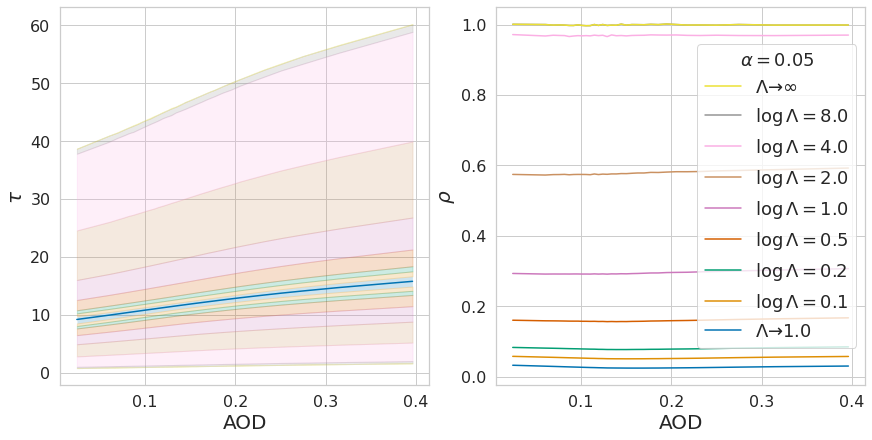

In [24]:
alpha = 0.05
idx_outcome = 2
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
    label=r"$\Lambda=$" + f"{np.exp(0.1):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C1",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
    label=r"$\Lambda=$" + f"{np.exp(0.2):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_1[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C2",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
    label=r"$\Lambda=$" + f"{np.exp(0.5):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_2[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C3",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_4[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_3[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C4",
    label=r"$\Lambda=$" + f"{np.exp(1.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_4[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_3[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C4",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_5[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_4[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C5",
    label=r"$\Lambda=$" + f"{np.exp(2.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_5[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_4[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C5",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_6[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_5[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C6",
    label=r"$\Lambda=$" + f"{np.exp(4.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_6[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_5[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C6",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_7[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_6[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C7",
    label=r"$\Lambda=$" + f"{np.exp(8.0):.01f}",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_7[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_6[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C7",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[1][idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apo_limits_7[1][idx_outcome], 1 - alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
    label=r"$\Lambda\to\infty$",
)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apo_limits_infty[0][idx_outcome], alpha / 2, axis=0),
    y2=np.quantile(apo_limits_7[0][idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    color="C8",
)
# _ = ax1.legend(
#     title=r"$\alpha=$" + f"{alpha}",
#     # loc="upper right",
# )
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

_ = sns.lineplot(
    x=treatments, 
    y=rho_0, 
    label=r"$\Lambda\to 1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_1,
    label=r"$\log{\Lambda}=0.1$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_2,
    label=r"$\log{\Lambda}=0.2$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_3,
    label=r"$\log{\Lambda}=0.5$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_4,
    label=r"$\log{\Lambda}=1.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_5,
    label=r"$\log{\Lambda}=2.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_6,
    label=r"$\log{\Lambda}=4.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_7,
    label=r"$\log{\Lambda}=8.0$",
)
_ = sns.lineplot(
    x=treatments, 
    y=rho_7,
    label=r"$\Lambda\to\infty$",
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(
    handles[::-1], 
    labels[::-1], 
    title=r"$\alpha=$" + f"{alpha}", 
    # loc='right'
)
_ = ax2.set_ylabel(r"$\rho$")
_ = ax2.set_xlabel("AOD")